## Problem set: Week 7 (Resting fMRI)
In this problem set you will load the correlation data from one of the Midnight Scan Club subjects (which has already been extracted using the Glasser MMP parcellation) and perform several analyses to characterize the network.

As before, skeletal code is provided - please fill in any areas where you see ...


In [268]:
import os,pickle,sys
import numpy,pandas
import nilearn.datasets
import nilearn.plotting
import matplotlib.pyplot as plt
import scipy.stats
import networkx as nx
import sklearn.metrics
import bct
from collections import Counter

from brainnetworks.r2z import r_to_z,z_to_r
%matplotlib inline

datadir = nilearn.datasets.get_data_dirs()[0]
if not os.path.exists(datadir):
    os.mkdir(datadir)
    
atlasdir='/home/vagrant/brain-networks-course/data/HCP-MMP1'

labelfile=os.path.join(atlasdir,'MMP_yeo2011_networks.csv')
labeldata=pandas.read_csv(labelfile)


In [270]:
# first load the data

sub=1
corrtype='gsr'  # use data with global signal regression
scrubtype='full' # don't use scrubbing


subdir=os.path.join(datadir,'MSC/ds000224/derivatives/fmriprep/sub-MSC%02d/'%sub)

corrs=pickle.load(open(os.path.join(subdir,'sub-MSC%02d_task-rest_corrmtx.pkl'%sub),'rb'))



Now compute the mean correlation matrix across sesssions, using the r-to-z transform to first convert them to Z scores and then convert back to r values after averaging. The correlation data are stored in a dictionary, with the following key structure:

> ```corrs[session num][corrtype:{'gsr','nogsr'}][scrubtype:{'scrubbed','full'}]```

We will use corrtype and scrubtype as specified above

In [271]:
corrsum=numpy.zeros(corrs[1][corrtype][scrubtype].shape)
for s in corrs:
    sesscor=corrs[s][corrtype][scrubtype]
    corrsum+=r_to_z(sesscor)
    
meancorr=z_to_r(corrsum/len(corrs))
    



/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/brainnetworks/r2z.py:9: RuntimeWarning: divide by zero encountered in true_divide
  z=0.5*numpy.log((1.0+r)/(1.0-r))


**Problem 1**: Create a binary adjacency matrix with a density of 5%, and use this to create a NetworkX graph.  Be sure to do the following:

- exclude the diagonal when computing the cutoff 
- zero out the diagonal before creating the graph
- extract the giant component from the graph (calling the resulting variable ```Gc```)
- print the number of nodes in the giant component

In [272]:
# determine cutoff for 5% density of the correlation matrix
# using just the upper triangle of the matrix
thresh= 95  # in percent
cutoff= scipy.stats.scoreatpercentile(meancorr[numpy.triu_indices_from(meancorr,1)],thresh)

#create symmetric binary adjacency matrix
# be sure to convert to integer
adjmtx = (meancorr >= cutoff)#.astype('int')

# zero out the diagonal in the adjmtx
adjmtx[numpy.eye(len(adjmtx),dtype='bool')]=0

# Create numpy graph
G= nx.from_numpy_matrix(adjmtx)

# create graph for giant component
# first get all component subgraphs
comps=[i for i in nx.connected_component_subgraphs(G)]
# then take the largest
Gc=max(comps, key=len)
#Gc=comps[0] russ solution 

print('Giant component includes %d out of %d total nodes'%(len(Gc.nodes),len(G.nodes)))

# grab the label data for only the nodes in the giant component
labeldata_Gc=labeldata.loc[list(Gc.nodes)]
# add degree values to labeldata frame
labeldata_Gc['degree']=[Gc.degree[i] for i in labeldata_Gc.index]




Giant component includes 356 out of 360 total nodes


/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


**Problem 3**: Perform community detection on the graph, using the Louvain algorithm for undirected binary graphs as implemented in the bct python package, and compute their overlap with the Yeo 7 network parcellation



In [273]:
# compute modularity using bct
adjmtx = nx.to_numpy_array(Gc)
mod_binary = bct.modularity_louvain_und(adjmtx)

print('modularity:',mod_binary[1])
print('Multilevel modularity optimization identifed %d communities'%len(numpy.unique(mod_binary[0])))

# compute adjusted rand score using method from sklearn.metrics
ari= sklearn.metrics.adjusted_rand_score(mod_binary[0],labeldata_Gc['Yeo7'])
print('Adjusted Rand index compared to Yeo 7 networks: %0.3f'%ari)

# how well do the communities match using rand_score 1 high and 0 none

modularity: 0.6580261473858411
Multilevel modularity optimization identifed 7 communities
Adjusted Rand index compared to Yeo 7 networks: 0.394


**Problem 4**: Estimate the normalized rich club coefficient for this network and plot the coefficients across the range of degree values.  Find the smallest degree value  for which the rich club coefficient is greater than 2, which we will use to define the rich club nodes.

error, retrying
error, retrying
degree_cutoff: 35
13 nodes in rich club


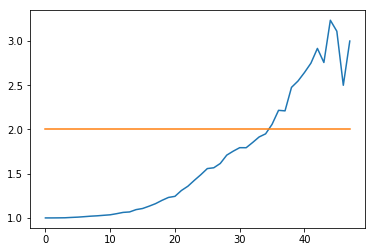

In [274]:
# embed computation of rcc within a try/catch since it fails
# pretty regularly with a ZeroDivisionError
good_rcc=False
while not good_rcc:
    try:
        rcc = nx.rich_club_coefficient(G, normalized=True)
        good_rcc=True
    except ZeroDivisionError:
        print('error, retrying')
        
# put into a data frame
rccdata=pandas.DataFrame([(i,rcc[i]) for i in rcc.keys()],
                         columns=['degree','rcc'])

# find the degree cutoff for rcc >= 2
degree_cutoff = numpy.min(rccdata[rccdata['rcc']>=2]['degree'])
print('degree_cutoff:',degree_cutoff) 

richclub = plt.plot(rccdata['rcc'])
plt.plot([0,max(rccdata['degree'])],[2,2])
#plt.xlabel('number_of_degrees')
#plt.ylabel('rich_club_coeff')

# compute the size of the rich club
rc_size=numpy.sum(rccdata['degree']>=degree_cutoff)
print(rc_size,'nodes in rich club')

**Problem 5:** For each of the Yeo7 networks, determine how many rich club members fall within that network.

In [275]:
# first create a data frame containing label data just for rcc members

labeldata_rcc=labeldata_Gc.loc[labeldata_Gc['degree']>=degree_cutoff]

# use collections.Counter to generate a list of the counts of members in each
# Yeo7 network
c=dict(Counter(labeldata_rcc['YeoDesc7']))
print(c)

{'Visual': 21, 'DorsalAttention': 6, 'VentralAttention': 13, 'Default': 2, 'Somatomotor': 1}


**Problem 6:** First, compute the node betweenness centrality and edge betweeness centrality for the giant component network.  

In [276]:
# compute edge betweenness centrality
ebc = nx.edge_betweenness_centrality(Gc)

# compute node betweenness centrality
bc = nx.betweenness_centrality(Gc)

Then, compute the mean betweenness centrality for edges separated by whether they include 0, 1, or 2 members of the rich club, and print out the mean values for each.

Now compute the mean betweenness centrality for nodes, separated by whether the nodes are members of the rich club or not, and print the values of each. 

How does centrality of both nodes and edges relate to rich club membership?  Please explain (insert your answer in the following cell).